In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from adjustText import adjust_text

# Path to the Arial font file
from matplotlib import font_manager
font_path = os.path.expanduser('~/fonts/Arial.ttf')

# Add the font to matplotlib
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'

Number of upregulated genes: 71
Number of downregulated genes: 140
Penk -4.75236044137464 2.0958880431259201e-47
Fosb 1.13847745418197 1.44035735420061e-29
Capg -1.56297023964165 6.04854087514404e-28
Klrg1 -1.66921571697538 2.74711916022095e-23
Klf6 1.10213378188578 3.8061511037669e-22
Nav2 -2.10502268882426 1.1857681679569201e-20
Il1rl1 -2.69192523768861 3.4747592020980704e-19
Tnfrsf9 -1.51819342453901 1.30202579529206e-17
Glrx -1.46359247046264 8.99562401798748e-15
Ltb4r1 -2.56025420840789 7.84856321588599e-13
Sdc4 -2.20597920960868 2.58437467232311e-12
Rgs16 -2.53980138080494 4.95226586788483e-12
Tox2 -3.47999887500445 5.410058737838809e-11
Tnfaip3 1.14392209619147 3.95997113544327e-10
Sdcbp2 -1.74822828462073 5.09257686132549e-10
Smco4 -1.22089441055304 5.6129818230960105e-09
Il1r2 -2.8867516681945 6.43942562445449e-09
Itgb8 -2.57906617265341 1.01033953482486e-08
Dst -1.94045428007406 1.20237151004794e-08
Arl5a -1.01707080823565 2.06365194481405e-08


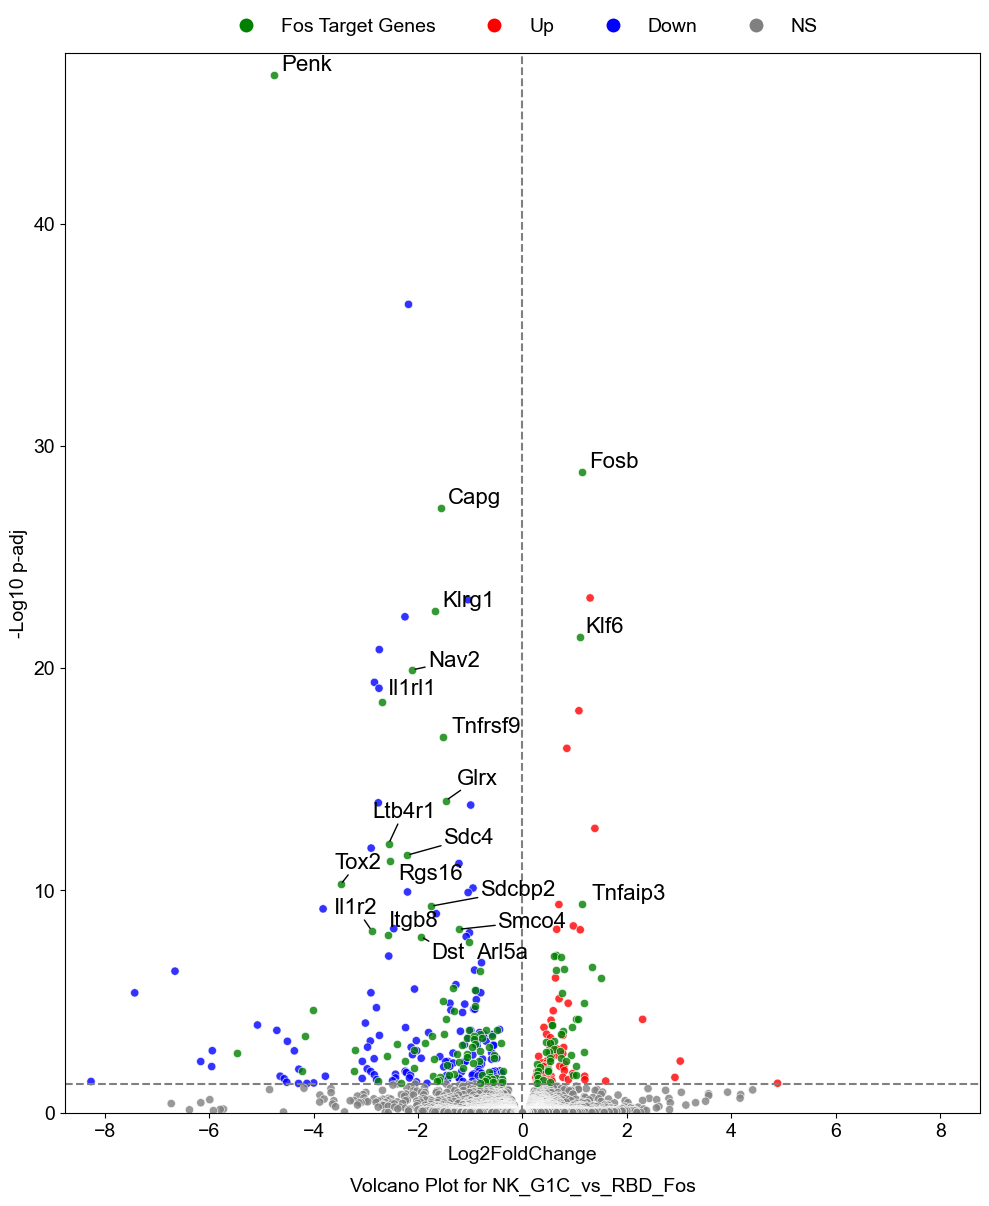

In [3]:

# File paths
file2_path = 'samples/20240708/NK_cells_G1C_vs_RBD.dds.res'
output_plot_path = 'plots/chip/NK_Fos_chip_volcano_plot.pdf'
gene_list_path = 'chip_genes/NK_genes.csv'

# Read the input files
data = pd.read_csv(file2_path, sep='\t', index_col=0)

# Calculate -log10(padj)
data['-log10padj'] = -np.log10(data['padj'])

# Load gene list from CSV
gene_list_data = pd.read_csv(gene_list_path)
gene_list = []
for gene in gene_list_data['fos']:
    if pd.notna(gene):  # Check if gene name is not NA
        gene_list.append(gene.strip())  # Append gene name to list

gene_color = 'green'

# Assign colors based on the specified criteria and highlight genes in gene_list as green
def color_dots(row):
    if row.name in gene_list:
        return gene_color
    elif row['padj'] > 0.05:
        return 'gray'
    elif row['log2FoldChange'] > 0:
        return 'red'
    else:
        return 'blue'

data['color'] = data.apply(color_dots, axis=1)

# Count upregulated and downregulated genes
upregulated_count = (data['color'] == 'red').sum()
downregulated_count = (data['color'] == 'blue').sum()

print(f"Number of upregulated genes: {upregulated_count}")
print(f"Number of downregulated genes: {downregulated_count}")

# Separate the data into two groups: green dots (genes in gene_list) and others
data_non_gene_list = data[~data.index.isin(gene_list)]
data_gene_list = data[data.index.isin(gene_list)]

# Create the volcano plot
plt.figure(figsize=(10, 12))

# Plot the non-gene-list dots first
plt.scatter(data_non_gene_list['log2FoldChange'], data_non_gene_list['-log10padj'], 
            c=data_non_gene_list['color'], alpha=0.8, edgecolors='w', linewidth=0.5)

# Plot the gene-list dots (green) last to make sure they are on top
plt.scatter(data_gene_list['log2FoldChange'], data_gene_list['-log10padj'], 
            c=gene_color, alpha=0.8, edgecolors='w', linewidth=0.5)

plt.axhline(y=-np.log10(0.05), linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='gray')

# Set y-axis to start from 0
plt.ylim(0, data['-log10padj'].max() + 1)

# Calculate the maximum absolute log2FoldChange
max_abs_log2FC = np.abs(data['log2FoldChange']).max()

# Set x-axis limits symmetrically around log2FC=0
plt.xlim(-max_abs_log2FC - 0.5, max_abs_log2FC + 0.5)

# Labeling the plot
plt.text(0.5, -0.07, 'Volcano Plot for NK_G1C_vs_RBD_Fos', ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)
plt.xlabel('Log2FoldChange', fontsize=14)
plt.ylabel('-Log10 p-adj', fontsize=14)

# Change font size of x and y axis ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Create custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=gene_color, markersize=10, label='Fos Target Genes', markeredgewidth=0),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Up', markeredgewidth=0),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Down', markeredgewidth=0),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='NS', markeredgewidth=0)
]

# Add the legend
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), fontsize=14, frameon=False, ncol=4)

# Select the top 20 genes with the lowest padj values for labeling
top_genes = data.loc[data.index.isin(gene_list)].sort_values('padj').head(20).index

# Annotate genes on the plot
texts = []
for gene in top_genes:
    x = data.loc[gene, 'log2FoldChange']  
    y = data.loc[gene, '-log10padj']
    texts.append(plt.text(x=x, y=y, s=gene, fontsize=16, weight='bold'))
    print(gene, x, data.loc[gene, 'padj'])

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'))

# Save the plot
plt.tight_layout()
plt.savefig(output_plot_path, dpi=300)
plt.show()

Number of upregulated genes: 26
Number of downregulated genes: 7
Klf2 0.384774817087968 0.0086467984128272


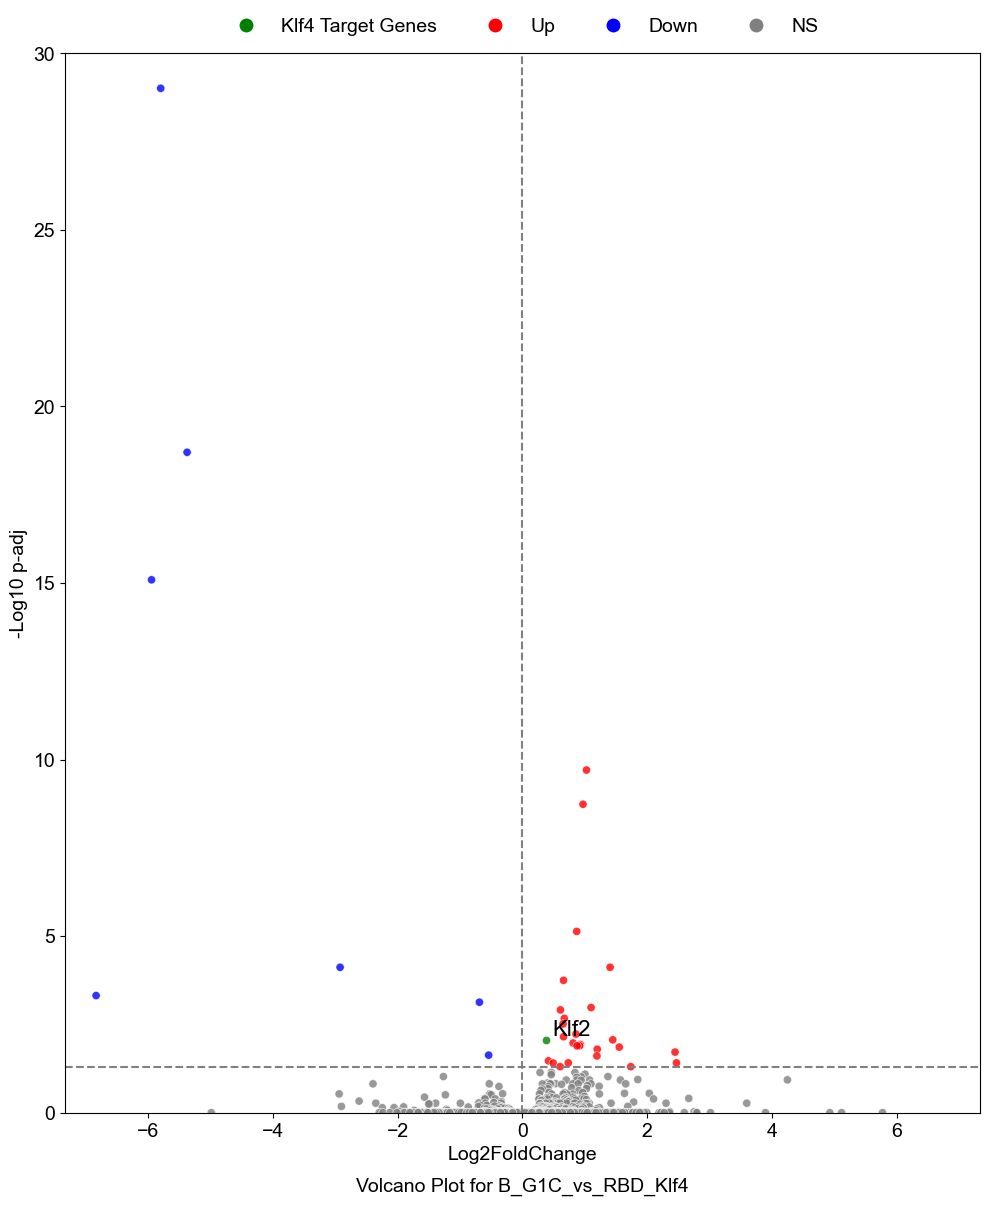

In [5]:

# File paths
file2_path = 'samples/20240708/B_G1C_vs_RBD.dds.res'
output_plot_path = 'plots/chip/B_Klf4_chip_volcano_plot.pdf'
gene_list_path = 'chip_genes/B_genes.csv'

# Read the input files
data = pd.read_csv(file2_path, sep='\t', index_col=0)

# Calculate -log10(padj)
data['-log10padj'] = -np.log10(data['padj'])

# Load gene list from CSV
gene_list_data = pd.read_csv(gene_list_path)
gene_list = []
for gene in gene_list_data['klf4']:
    if pd.notna(gene):  # Check if gene name is not NA
        gene_list.append(gene.strip())  # Append gene name to list

gene_color = 'green'

# Assign colors based on the specified criteria and highlight genes in gene_list as green
def color_dots(row):
    if row.name in gene_list:
        return gene_color
    elif row['padj'] > 0.05:
        return 'gray'
    elif row['log2FoldChange'] > 0:
        return 'red'
    else:
        return 'blue'

data['color'] = data.apply(color_dots, axis=1)

# Count upregulated and downregulated genes
upregulated_count = (data['color'] == 'red').sum()
downregulated_count = (data['color'] == 'blue').sum()

print(f"Number of upregulated genes: {upregulated_count}")
print(f"Number of downregulated genes: {downregulated_count}")

# Separate the data into two groups: green dots (genes in gene_list) and others
data_non_gene_list = data[~data.index.isin(gene_list)]
data_gene_list = data[data.index.isin(gene_list)]

# Create the volcano plot
plt.figure(figsize=(10, 12))

# Plot the non-gene-list dots first
plt.scatter(data_non_gene_list['log2FoldChange'], data_non_gene_list['-log10padj'], 
            c=data_non_gene_list['color'], alpha=0.8, edgecolors='w', linewidth=0.5)

# Plot the gene-list dots (green) last to make sure they are on top
plt.scatter(data_gene_list['log2FoldChange'], data_gene_list['-log10padj'], 
            c=gene_color, alpha=0.8, edgecolors='w', linewidth=0.5)

plt.axhline(y=-np.log10(0.05), linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='gray')

# Set y-axis to start from 0
plt.ylim(0, data['-log10padj'].max() + 1)

# Calculate the maximum absolute log2FoldChange
max_abs_log2FC = np.abs(data['log2FoldChange']).max()

# Set x-axis limits symmetrically around log2FC=0
plt.xlim(-max_abs_log2FC - 0.5, max_abs_log2FC + 0.5)

# Labeling the plot
plt.text(0.5, -0.07, 'Volcano Plot for B_G1C_vs_RBD_Klf4', ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)
plt.xlabel('Log2FoldChange', fontsize=14)
plt.ylabel('-Log10 p-adj', fontsize=14)

# Change font size of x and y axis ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Create custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=gene_color, markersize=10, label='Klf4 Target Genes', markeredgewidth=0),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Up', markeredgewidth=0),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Down', markeredgewidth=0),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='NS', markeredgewidth=0)
]

# Add the legend
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), fontsize=14, frameon=False, ncol=4)

# Select the top 20 genes with the lowest padj values for labeling
top_genes = data.loc[data.index.isin(gene_list)].sort_values('padj').head(20).index

# Annotate genes on the plot
texts = []
for gene in top_genes:
    x = data.loc[gene, 'log2FoldChange']  
    y = data.loc[gene, '-log10padj']
    texts.append(plt.text(x=x, y=y, s=gene, fontsize=16, weight='bold'))
    print(gene, x, data.loc[gene, 'padj'])

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'))

# Save the plot
plt.tight_layout()
plt.savefig(output_plot_path, dpi=300)
plt.show()

Number of upregulated genes: 262
Number of downregulated genes: 94
Gsn 1.07771411485235 2.5447666763443102e-14
Ccnb2 1.31540656271833 1.22217985233124e-12
Aspm 1.15868833587526 3.9120880119104995e-12
Ube2c 1.30251802376317 5.87257591044361e-12
Pimreg 1.62902003624857 6.98074867296784e-12
Cdca3 0.959883649176682 8.145298666647551e-10
Sgo1 1.1189565612041 1.65105717636508e-09
Cdkn3 1.18022205475182 5.17053462035127e-09
Cdca8 0.974359000923534 6.550953215696611e-09
Cenpf 1.10054476256601 1.25142493785284e-08
Arhgap19 1.21149009463426 2.82023058856006e-08
Nek2 1.10886467934972 1.27280908059905e-07
Lgals1 0.526196469235317 2.06802417203285e-07
Hmmr 0.998264068964085 2.2633225430306e-07
Cks2 0.855804838362494 2.2633225430306e-07
Il7r 0.527698132907336 3.14495997819623e-07
Kif18b 1.11261703913677 3.66606936037769e-07
Klf6 1.13607186282479 5.69493638846354e-07
Ect2 1.17465141113574 6.60398426052644e-07
Hmgb1 0.756690865416203 8.81142565404132e-07


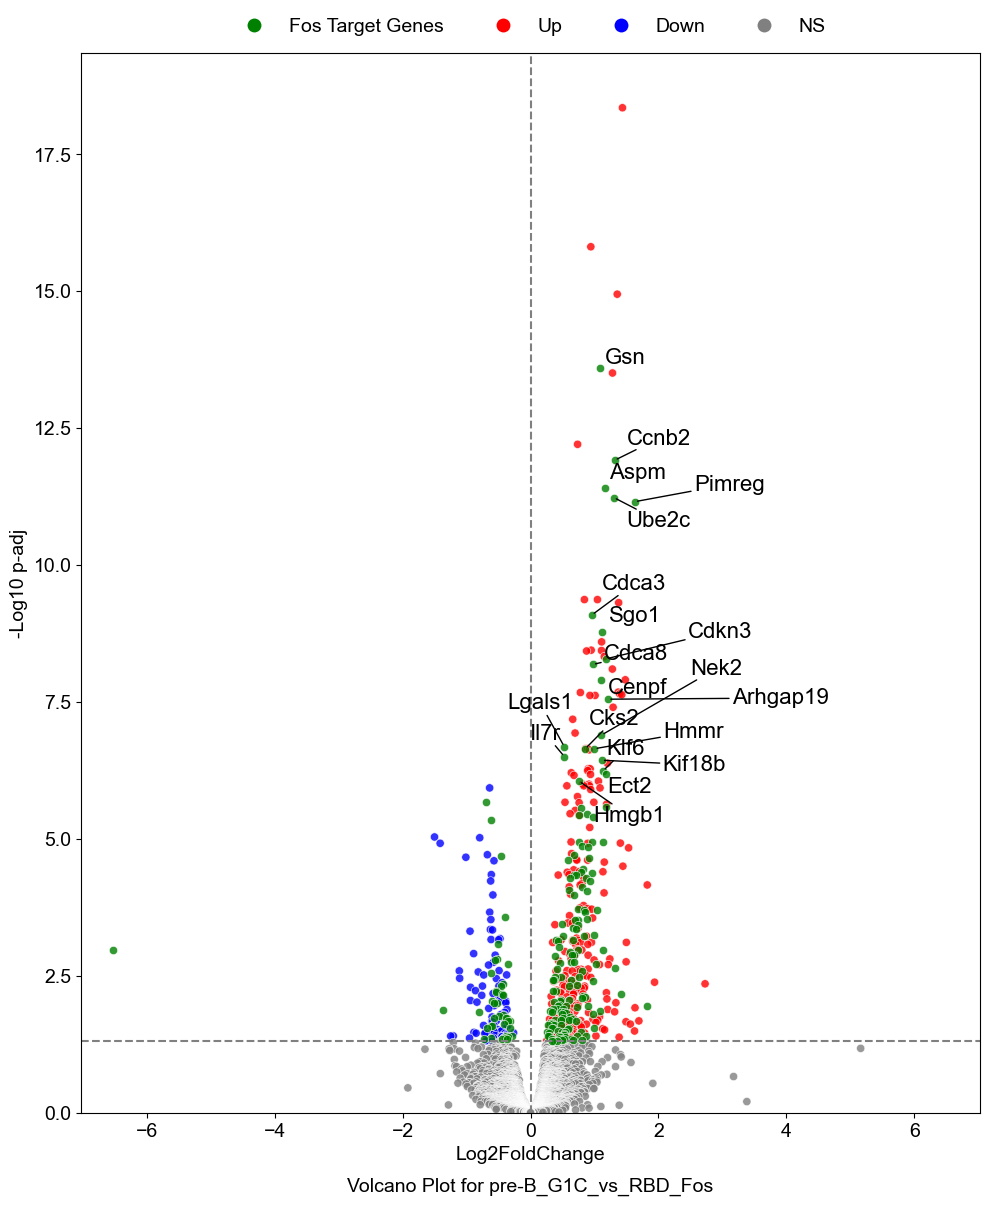

In [7]:

# File paths
file2_path = 'samples/20240708/pre-B_G1C_vs_RBD.dds.res'
output_plot_path = 'plots/chip/pre-B_Fos_chip_volcano_plot.pdf'
gene_list_path = 'chip_genes/preB_genes.csv'

# Read the input files
data = pd.read_csv(file2_path, sep='\t', index_col=0)

# Calculate -log10(padj)
data['-log10padj'] = -np.log10(data['padj'])

# Load gene list from CSV
gene_list_data = pd.read_csv(gene_list_path)
gene_list = []
for gene in gene_list_data['fos']:
    if pd.notna(gene):  # Check if gene name is not NA
        gene_list.append(gene.strip())  # Append gene name to list

gene_color = 'green'

# Assign colors based on the specified criteria and highlight genes in gene_list as green
def color_dots(row):
    if row.name in gene_list:
        return gene_color
    elif row['padj'] > 0.05:
        return 'gray'
    elif row['log2FoldChange'] > 0:
        return 'red'
    else:
        return 'blue'

data['color'] = data.apply(color_dots, axis=1)

# Count upregulated and downregulated genes
upregulated_count = (data['color'] == 'red').sum()
downregulated_count = (data['color'] == 'blue').sum()

print(f"Number of upregulated genes: {upregulated_count}")
print(f"Number of downregulated genes: {downregulated_count}")

# Separate the data into two groups: green dots (genes in gene_list) and others
data_non_gene_list = data[~data.index.isin(gene_list)]
data_gene_list = data[data.index.isin(gene_list)]

# Create the volcano plot
plt.figure(figsize=(10, 12))

# Plot the non-gene-list dots first
plt.scatter(data_non_gene_list['log2FoldChange'], data_non_gene_list['-log10padj'], 
            c=data_non_gene_list['color'], alpha=0.8, edgecolors='w', linewidth=0.5)

# Plot the gene-list dots (green) last to make sure they are on top
plt.scatter(data_gene_list['log2FoldChange'], data_gene_list['-log10padj'], 
            c=gene_color, alpha=0.8, edgecolors='w', linewidth=0.5)

plt.axhline(y=-np.log10(0.05), linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='gray')

# Set y-axis to start from 0
plt.ylim(0, data['-log10padj'].max() + 1)

# Calculate the maximum absolute log2FoldChange
max_abs_log2FC = np.abs(data['log2FoldChange']).max()

# Set x-axis limits symmetrically around log2FC=0
plt.xlim(-max_abs_log2FC - 0.5, max_abs_log2FC + 0.5)

# Labeling the plot
plt.text(0.5, -0.07, 'Volcano Plot for pre-B_G1C_vs_RBD_Fos', ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)
plt.xlabel('Log2FoldChange', fontsize=14)
plt.ylabel('-Log10 p-adj', fontsize=14)

# Change font size of x and y axis ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Create custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=gene_color, markersize=10, label='Fos Target Genes', markeredgewidth=0),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Up', markeredgewidth=0),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Down', markeredgewidth=0),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='NS', markeredgewidth=0)
]

# Add the legend
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), fontsize=14, frameon=False, ncol=4)

# Select the top 20 genes with the lowest padj values for labeling
top_genes = data.loc[data.index.isin(gene_list)].sort_values('padj').head(20).index

# Annotate genes on the plot
texts = []
for gene in top_genes:
    x = data.loc[gene, 'log2FoldChange']  
    y = data.loc[gene, '-log10padj']
    texts.append(plt.text(x=x, y=y, s=gene, fontsize=16, weight='bold'))
    print(gene, x, data.loc[gene, 'padj'])

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'))

# Save the plot
plt.tight_layout()
plt.savefig(output_plot_path, dpi=300)
plt.show()